In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, get_scheduler, SchedulerType
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
from datasets import Dataset
import numpy as np
import random
import pandas as pd

In [2]:
df = pd.read_csv("filtered_data.tsv", sep="\t")
dataset = Dataset.from_pandas(df)
print(len(dataset))

441187


In [3]:
def preprocess_function(examples):
    return {
        "Incorrect": str(examples["Incorrect"]),
        "Corrected": str(examples["Corrected"])
    }
small_dataset = dataset.train_test_split(train_size=0.1, seed=42)["train"]
dataset = small_dataset.map(preprocess_function)

Map:   0%|          | 0/44118 [00:00<?, ? examples/s]

In [4]:
split = dataset.train_test_split(test_size=0.2)
train_data = split["train"]
valid_data = split["test"]
print(len(train_data))
print(len(valid_data))

35294
8824


In [5]:
from transformers import AutoTokenizer, BartForConditionalGeneration

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large")

def tokenize_function(examples):
    prefix = "grammar error correction: "
    # Add prefix to incorrect texts
    incorrect_texts = [prefix + str(text) for text in examples["Incorrect"]]
    correct_texts = [str(text) for text in examples["Corrected"]]
    
    # Calculate the increased max_length to accommodate the prefix
    prefix_token_count = len(tokenizer.encode(prefix)) - 2  # -2 for special tokens
    adjusted_max_length = 128 + prefix_token_count
    
    inputs = tokenizer(incorrect_texts, padding="max_length", truncation=True, max_length=adjusted_max_length)
    targets = tokenizer(correct_texts, padding="max_length", truncation=True, max_length=128)

    labels = targets["input_ids"]
    labels = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label_seq]
        for label_seq in labels
    ]
    inputs["labels"] = labels
    return inputs


train_data = train_data.map(tokenize_function, batched=True)
valid_data = valid_data.map(tokenize_function, batched=True)


def correct_grammar(text, model, tokenizer):
    # Add prefix to input text
    PREFIX = "grammar error correction: "
    prefixed_text = PREFIX + text
    
    # Tokenize with adjusted max_length
    prefix_token_count = len(tokenizer.encode(PREFIX)) - 2
    inputs = tokenizer(prefixed_text, return_tensors="pt", padding=True, 
                      truncation=True, max_length=128 + prefix_token_count)
    
    # Move to same device as model
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.attention_mask.to(model.device)
    
    # Generate output
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,
        num_beams=4,
        early_stopping=True,
        length_penalty=2.0,
        no_repeat_ngram_size=3
    )
    
    # Decode output
    corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return corrected_text

Using TensorFlow backend.


Map:   0%|          | 0/35294 [00:00<?, ? examples/s]

Map:   0%|          | 0/8824 [00:00<?, ? examples/s]

In [6]:
from transformers import Seq2SeqTrainingArguments, AutoModelForSeq2SeqLM



# Load pre-trained BART model
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large")
model.gradient_checkpointing_enable()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)



training_args = Seq2SeqTrainingArguments(
    output_dir="./bart_grammar_correction",
    eval_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",
    logging_dir="./logs",  # For TensorBoard
    logging_steps=10,
    
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps = 2,  # Effective batch size becomes 8 * 2 = 16
    
    fp16=True,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_steps=500,  # Added warmup steps
    
    predict_with_generate=True,
    report_to="none",
    metric_for_best_model="f0_5",
    load_best_model_at_end=True,
    
)

In [7]:
import torch
import nltk
from nltk.translate.gleu_score import corpus_gleu
from nltk.tokenize import word_tokenize
from nltk.translate.gleu_score import sentence_gleu
from transformers import EvalPrediction
import numpy as np
import jiwer  # for character error rate (pip install jiwer if not installed)

def postprocess_labels(labels, tokenizer):
    return [
        [token if token != -100 else tokenizer.pad_token_id for token in label_seq]
        for label_seq in labels
    ]
    
def compute_metrics(eval_pred):
    preds = eval_pred.predictions
    labels = eval_pred.label_ids
    preds, labels = eval_pred

    # Convert logits to predicted token ids
    clean_preds = postprocess_labels(preds, tokenizer)
    pred_texts = tokenizer.batch_decode(clean_preds, skip_special_tokens=True)
    clean_labels = postprocess_labels(labels, tokenizer)
    label_texts = tokenizer.batch_decode(clean_labels, skip_special_tokens=True)

    tokenized_preds = [word_tokenize(p,language="english", preserve_line=True) for p in pred_texts]
    tokenized_labels = [word_tokenize(l,language="english", preserve_line=True) for l in label_texts]

    # Compute sentence-level GLEU
    gleu_scores = []
    for pred, ref in zip(tokenized_preds, tokenized_labels):
        if len(pred) >= 1 and len(ref) >= 1:
            try:
                score = sentence_gleu([ref], pred)  # ref must be wrapped in a list
                gleu_scores.append(score)
            except Exception:
                gleu_scores.append(0.0)
        else:
            gleu_scores.append(0.0)

    avg_sentence_gleu = np.mean(gleu_scores)

    # Character Error Rate
    cer_scores = [jiwer.cer(ref, hyp) for ref, hyp in zip(label_texts, pred_texts)]
    cer = np.mean(cer_scores)
    
    # Precision, Recall, F0.5
    TP = 0  # Correct tokens
    FP = 0  # Extra tokens in pred
    FN = 0  # Missing tokens in pred

    for pred, label in zip(tokenized_preds, tokenized_labels):
        min_len = min(len(pred), len(label))
        for i in range(min_len):
            if pred[i] == label[i]:
                TP += 1
            else:
                FP += 1
                FN += 1
        FP += max(0, len(pred) - len(label))  # Remaining pred tokens are FP
        FN += max(0, len(label) - len(pred))  # Remaining label tokens are FN

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    beta_squared = 0.5 ** 2
    f0_5 = (1 + beta_squared) * precision * recall / (beta_squared * precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "gleu": avg_sentence_gleu,
        "cer": cer,
        "precision": precision,
        "recall": recall,
        "f0_5": f0_5
    }
def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return torch.argmax(logits, dim=-1)

In [8]:
from transformers import Seq2SeqTrainer
import torch

class CustomPrefixTrainer(Seq2SeqTrainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.prefix = "grammar error correction: "
        
    def prediction_step(
        self,
        model,
        inputs,
        prediction_loss_only,
        ignore_keys=None,
    ):
        """
        Overriding prediction_step to use custom prefix for generation.
        """
        if prediction_loss_only:
            return super().prediction_step(
                model, inputs, prediction_loss_only=True, ignore_keys=ignore_keys
            )
            
        has_labels = "labels" in inputs
        inputs = self._prepare_inputs(inputs)
        
        # Compute loss with labels
        with torch.no_grad():
            loss, generated_tokens = self.compute_loss(model, inputs, return_outputs=True)
            loss = loss.mean().detach()
        
        if self.args.predict_with_generate and not prediction_loss_only:
            # Get tokenizer
            tokenizer = self.tokenizer
            
            # Prepare generation inputs
            generation_inputs = {}
            # Get the input_ids without the prefix
            input_ids = inputs["input_ids"]
            attention_mask = inputs["attention_mask"]
            
            # Add prefix to input_ids
            batch_size = input_ids.shape[0]
            prefix_tokens = tokenizer(
                [self.prefix] * batch_size, 
                return_tensors="pt",
                add_special_tokens=False
            ).input_ids.to(input_ids.device)
            
            # Remove BOS token from input_ids if it exists
            if tokenizer.bos_token_id is not None:
                # Check if input_ids start with BOS token
                if (input_ids[:, 0] == tokenizer.bos_token_id).all():
                    input_ids = input_ids[:, 1:]
                    attention_mask = attention_mask[:, 1:]
            
            # Concatenate prefix with input_ids
            prefixed_input_ids = torch.cat([prefix_tokens, input_ids], dim=1)
            
            # Update attention mask
            prefix_attention_mask = torch.ones(
                (batch_size, prefix_tokens.shape[1]),
                dtype=attention_mask.dtype,
                device=attention_mask.device
            )
            prefixed_attention_mask = torch.cat([prefix_attention_mask, attention_mask], dim=1)
            
            # Set up generation inputs
            generation_inputs["input_ids"] = prefixed_input_ids
            generation_inputs["attention_mask"] = prefixed_attention_mask
            
            # Generate
            generated_tokens = self.model.generate(
                **generation_inputs,
                max_length=128,
                num_beams=4,
                early_stopping=True,
                length_penalty=2.0,
                no_repeat_ngram_size=3
            )
            
            # Get labels
            labels = inputs["labels"]
            
            if has_labels:
                labels = inputs["labels"]
                if labels.shape[-1] < generated_tokens.shape[-1]:
                    labels = self._pad_tensors_to_max_len(labels, generated_tokens.shape[-1])
                elif labels.shape[-1] > generated_tokens.shape[-1]:
                    generated_tokens = self._pad_tensors_to_max_len(
                        generated_tokens, labels.shape[-1]
                    )
            
            return (loss, generated_tokens, labels)
        
        return (loss, None, None)

In [9]:

trainer = CustomPrefixTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=valid_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)



C:\Users\dmin\AppData\Local\Temp\ipykernel_27972\701089728.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomPrefixTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [10]:
trainer.train()
metrics = trainer.evaluate()
print(metrics)

Epoch,Training Loss,Validation Loss,Gleu,Cer,Precision,Recall,F0 5
1,0.657300,0.735329,0.633330,0.181466,0.538482,0.530186,0.536802
2,0.649900,0.727459,0.637733,0.176380,0.542009,0.533201,0.540224
3,0.585200,0.701074,0.641570,0.176431,0.544801,0.536435,0.543107
4,0.510100,0.681493,0.641308,0.178631,0.542483,0.535646,0.541102
5,0.481200,0.685684,0.641422,0.180942,0.541052,0.536313,0.540097
6,0.508200,0.709398,0.642073,0.178657,0.544848,0.538238,0.543513
7,0.468800,0.740296,0.640558,0.180475,0.541412,0.535939,0.540308
8,0.415800,0.716830,0.641285,0.179048,0.541331,0.534883,0.540029
9,0.373500,0.725652,0.641467,0.180239,0.542704,0.536345,0.541420
10,0.391600,0.743541,0.640353,0.181261,0.540920,0.536248,0.539979


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'eval_loss': 0.7093976736068726, 'eval_gleu': 0.6420726338610765, 'eval_cer': 0.17865694021225667, 'eval_precision': 0.5448481209439285, 'eval_recall': 0.5382384009100512, 'eval_f0_5': 0.5435132216784984, 'eval_runtime': 1097.7733, 'eval_samples_per_second': 8.038, 'eval_steps_per_second': 0.503, 'epoch': 15.0}


In [11]:
model.save_pretrained("./bart_grammar_corrector")
tokenizer.save_pretrained("./bart_grammar_corrector")

('./bart_grammar_corrector\\tokenizer_config.json',
 './bart_grammar_corrector\\special_tokens_map.json',
 './bart_grammar_corrector\\vocab.json',
 './bart_grammar_corrector\\merges.txt',
 './bart_grammar_corrector\\added_tokens.json',
 './bart_grammar_corrector\\tokenizer.json')

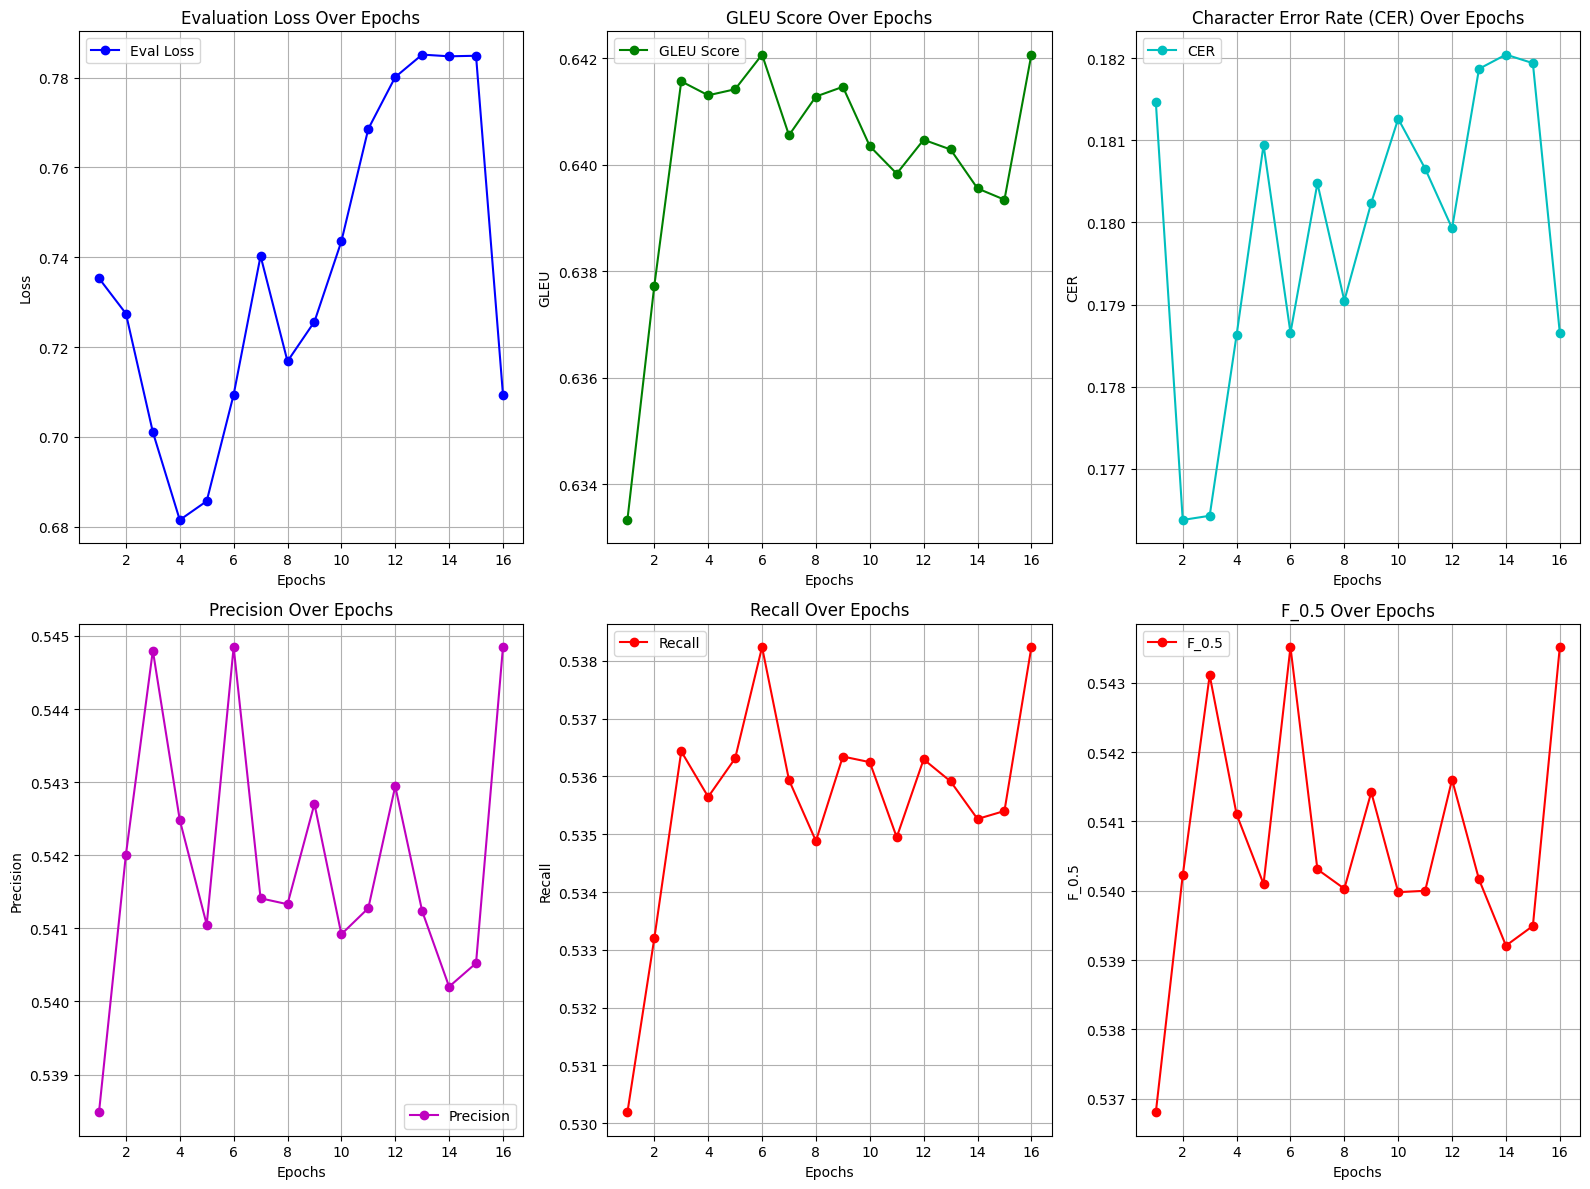

In [12]:
import matplotlib.pyplot as plt

# Extract logged history (simulated for demonstration purposes)
log_history = trainer.state.log_history

# Extract different metrics
train_losses = [entry["loss"] for entry in log_history if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
gleu_scores = [entry["eval_gleu"] for entry in log_history if "eval_gleu" in entry]
cer_scores = [entry["eval_cer"] for entry in log_history if "eval_cer" in entry]
precision = [entry["eval_precision"] for entry in log_history if "eval_precision" in entry]
recall = [entry["eval_recall"] for entry in log_history if "eval_recall" in entry]
f0_5 = [entry["eval_f0_5"] for entry in log_history if "eval_f0_5" in entry]

# Create epochs range based on the number of metrics
epochs = list(range(1, len(eval_losses) + 1))

# Plotting all metrics
plt.figure(figsize=(16, 12))

# Subplot 1: Evaluation Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, eval_losses, marker='o', linestyle='-', color='b', label="Eval Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Evaluation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Subplot 2: GLEU Score
if gleu_scores:
    plt.subplot(2, 3, 2)
    plt.plot(epochs, gleu_scores, marker='o', linestyle='-', color='g', label="GLEU Score")
    plt.xlabel("Epochs")
    plt.ylabel("GLEU")
    plt.title("GLEU Score Over Epochs")
    plt.legend()
    plt.grid(True)


# Subplot 2: Character Error Rate (CER)
if cer_scores:
    plt.subplot(2, 3, 3)
    plt.plot(epochs, cer_scores, marker='o', linestyle='-', color='c', label="CER")
    plt.xlabel("Epochs")
    plt.ylabel("CER")
    plt.title("Character Error Rate (CER) Over Epochs")
    plt.legend()
    plt.grid(True)

# Subplot 3: Precision
if precision:
    plt.subplot(2, 3, 4)
    plt.plot(epochs, precision, marker='o', linestyle='-', color='m', label="Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.title("Precision Over Epochs")
    plt.legend()
    plt.grid(True)

# Subplot 4: Recall
if recall:
    plt.subplot(2, 3, 5)
    plt.plot(epochs, recall, marker='o', linestyle='-', color='r', label="Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.title("Recall Over Epochs")
    plt.legend()
    plt.grid(True)

# Subplot 5: F0.5
if f0_5:
    plt.subplot(2, 3, 6)
    plt.plot(epochs, f0_5, marker='o', linestyle='-', color='r', label="F_0.5")
    plt.xlabel("Epochs")
    plt.ylabel("F_0.5")
    plt.title("F_0.5 Over Epochs")
    plt.legend()
    plt.grid(True)
    
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [14]:
import torch

#correct grammar function defined after tokenizer
    
# Load the model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("./bart_grammar_corrector")
tokenizer = AutoTokenizer.from_pretrained("./bart_grammar_corrector")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
    
test_sentences = [
    "He go to school.",
    "She like play soccer.",
    "I has a apple.",
    "We goes to the market every day.",
    "Tomorow we going shop",
    "She don’t likes going to the store because it make her feel bad every time she go.",
    "He walk to school every day even when it are raining",
    "Me and my cousin was going to the mall yesterday but we seen that it were closed so we decides to goes to the park instead where there was lots of childrens playing and peoples walking they dogs, and then we eaten some ice cream which it didn’t taste very good because they melted too fast and the cones was broke but we still was happy because we don’t got nothing better to do on them kind of days."
]

for sentence in test_sentences:
    corrected = correct_grammar(sentence, model,tokenizer)
    print(f"Incorrect: {sentence}")
    print(f"Corrected: {corrected}\n")

Incorrect: He go to school.
Corrected: He goes to school .

Incorrect: She like play soccer.
Corrected: She likes to play soccer

Incorrect: I has a apple.
Corrected: I have an apple .

Incorrect: We goes to the market every day.
Corrected: We go to the market every day .

Incorrect: Tomorow we going shop
Corrected: Tomorrow we are going to a shop

Incorrect: She don’t likes going to the store because it make her feel bad every time she go.
Corrected: She does n't like going to the store because it makes her feel bad every time she goes .

Incorrect: He walk to school every day even when it are raining
Corrected: He walks to school every day even when it is raining

Incorrect: Me and my cousin was going to the mall yesterday but we seen that it were closed so we decides to goes to the park instead where there was lots of childrens playing and peoples walking they dogs, and then we eaten some ice cream which it didn’t taste very good because they melted too fast and the cones was broke 